### Data and imports

In [20]:
import numpy as np
import yfinance as yf # to get our data

from sklearn.preprocessing import MinMaxScaler # to normalize our classes
from sklearn.model_selection import train_test_split # from tutorial code
from sklearn.metrics import accuracy_score, confusion_matrix # needed for plotting

import matplotlib.pyplot as plt

import pandas as pd

#### Get Data from Yahoo Finance
We are using S&P 500 index as our training and testing data

In [21]:
dfs = {} # Store all the data for our tickers, even though for now its just SP500
tickers = ['^GSPC',] # Ticker (identifier) for the SP500, which is arguably the most influential, we start with just this

# Got this code from https://www.kaggle.com/code/xxxxyyyy80008/predict-stock-market-crashes 
for ticker in tickers:
    cur_data = yf.Ticker(ticker)
    hist = cur_data.history(period="max")
    print(ticker, cur_data.info['shortName'], ticker, hist.shape, hist.index.min(), hist.index.max())
    dfs[ticker] = hist


^GSPC S&P 500 ^GSPC (24347, 7) 1927-12-30 00:00:00-05:00 2024-12-02 00:00:00-05:00


Let us see the data in the graph

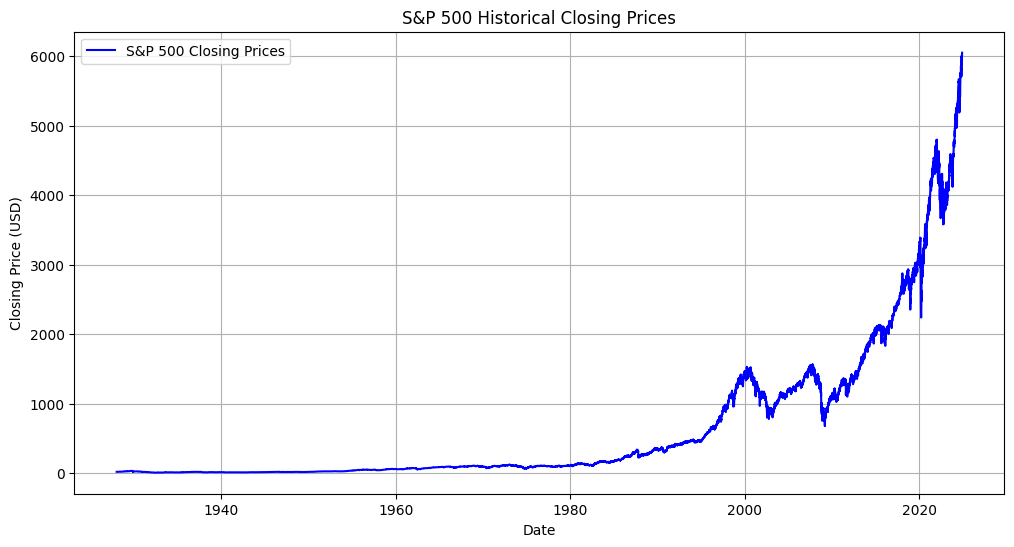

In [22]:
# Extract S&P 500 data
sp500_data = dfs['^GSPC']

# Use closing prices to plot the data
closing_prices = sp500_data['Close'].dropna()

# Convert index and values to np array
x = closing_prices.index.to_numpy()
y = closing_prices.to_numpy()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x, y, label='S&P 500 Closing Prices', color='blue')
plt.title("S&P 500 Historical Closing Prices")
plt.xlabel("Date")
plt.ylabel("Closing Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

### Data Preprocessing
In this project, we define a market crash as a drawdown of the 99.5% quantile

In [ ]:
# Calculates how much the price has gone down from its highest point, labeling those with a 0.005 quantile as crashes as per directive 1
# NOTE: got help from chatgpt for this function to find .pct_change, .cummax and .quantile
def calculate_drawdown_and_label(data, quantile_threshold=0.005):

    data['daily_return'] = data['Close'].pct_change()

    data['drawdown'] = data['Close'] / data['Close'].cummax() - 1

    crash_threshold = data['drawdown'].quantile(quantile_threshold)

    data['crash_label'] = (data['drawdown'] < crash_threshold).astype(int)

    return data

## Make the data we targeted the target (nice), we try to predict the market crashes 3 days in advance so shift_days = 3
def prepare_target(data, shift_days=3):
    data['target'] = (data['crash_label']).astype(int).shift(-shift_days) # complicated line that basically takes our data with crash label, turns the bools into an int, then shift the values by 3 days to predict in advance, since we want to predict 3 days in advance
    return data

# prepare the data
for ticker, data in dfs.items():
    data = calculate_drawdown_and_label(data) # get the drawdown for our data
    data = prepare_target(data)
    dfs[ticker] = data


### Pre-process data

In [35]:
def preprocess_data(data, sequence_length=15):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Close', 'daily_return', 'drawdown']].dropna())
    X = []
    y = []

    for i in range(len(scaled_data) - sequence_length):
        days = scaled_data[i:i+sequence_length]
        X.append(days)
        y.append(data['target'].iloc[i + sequence_length])

    X = np.array(X)
    y = np.array(y)
    
    y = y[~np.isnan(y)]
    X = X[:len(y)]
    return X, y, scaler

sequence_length = 3
X = {}
y = {}
scalers = {}
for ticker, data in dfs.items():
    X[ticker], y[ticker], scalers[ticker] = preprocess_data(data, sequence_length=sequence_length) 

X_all = np.concatenate([X[ticker] for ticker in X], axis=0)
y_all = np.concatenate([y[ticker] for ticker in y], axis=0)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

### ARIMA Model
As discussed in the literature review, the ARIMA model has 3 components, the autoregressive model, the moving average, and the intergration

In [ ]:
from statsmodels.tools.tools import add_constant
from statsmodels.regression.linear_model import OLS
class ARIMA():
    def __init__(self, p, q, d):
        self.p = p
        self.q = q
        self.d = d
    
    # autoregressive model
    def autoregression(self, X_train, lag):
        X = []
        y = []
        for t in range(lag, len(X_train)):
            X.append(X_train[t-lag:t])
            y.append(X_train[t])
        X, y = np.array(X), np.array(y)
        X = add_constant(X)

        model = OLS(y, X).fit()
        return model

    # intergration
    def difference(self, data, order):
        return data.diff(periods=order).dropna()

    # moving average
    def moving_average(self, errors, order):
        weights = np.ones(order) / order
        return np.convolve(errors, weights, mode="valid")
    
    def fit():
    
    def predict():